In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import keras

from google.colab import files
from google.colab import drive

In [ ]:
data = pd.read_csv('fer2013.csv')

Mounted at /content/drive


In [ ]:
n_samples = len(data)
# 80,20 split
n_samples_train = int(n_samples*0.8)
n_samples_test = int(n_samples*0.2)

w=48
h=48

y = data['emotion']
X = np.zeros((n_samples, w*h))
for i in range(n_samples):
    X[i] = np.fromstring(data['pixels'][i], sep=' ')


X = X.reshape(X.shape[0], 48, 48, 1)

from keras.utils import to_categorical
y_train = y[:n_samples_train]
y_train = to_categorical(y_train, num_classes=7)
y_test = y[n_samples_train : (n_samples_train + n_samples_test)]
y_test = to_categorical(y_test, num_classes=7)

X_train = X[:n_samples_train]
X_test = X[n_samples_train : (n_samples_train + n_samples_test)]

Check images and label

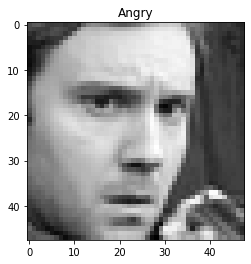

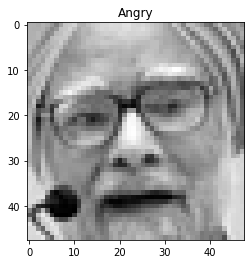

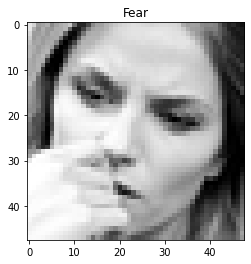

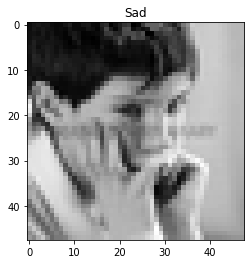

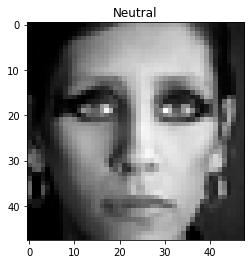

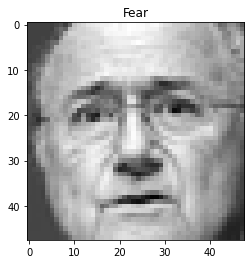

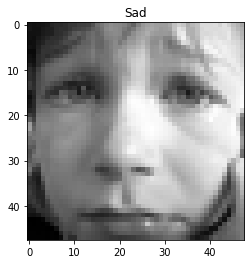

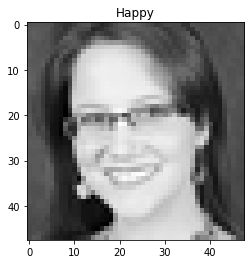

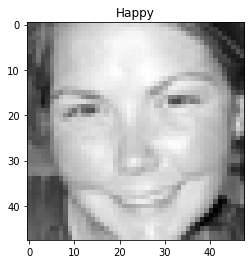

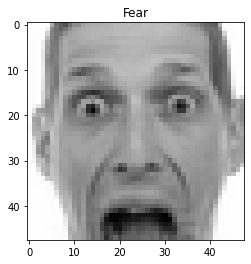

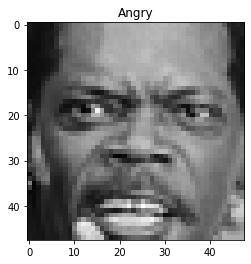

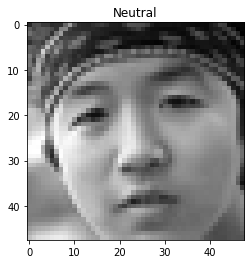

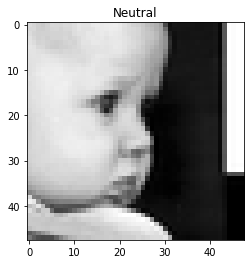

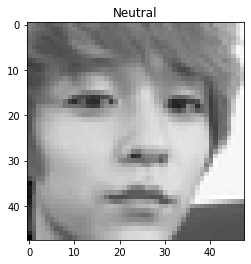

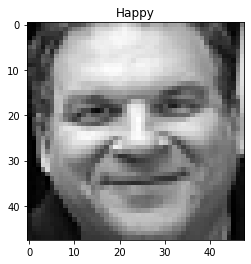

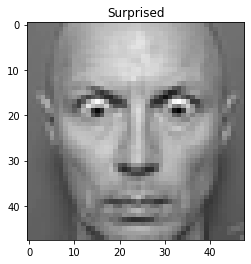

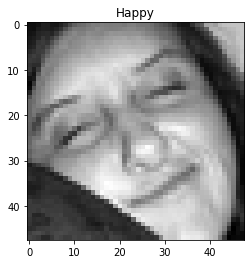

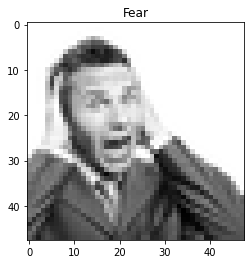

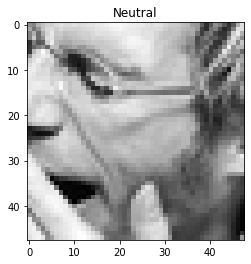

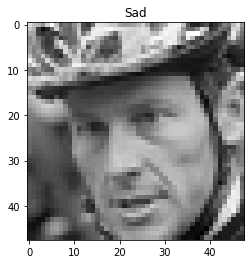

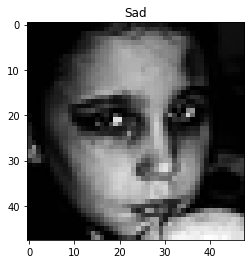

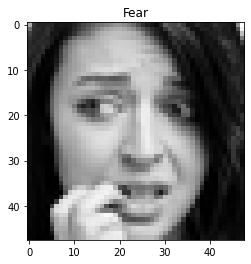

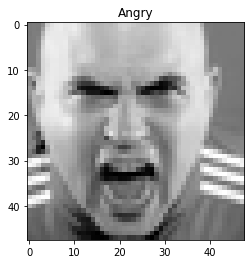

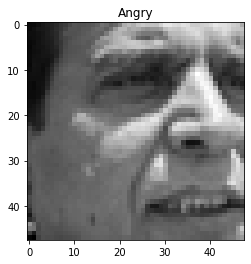

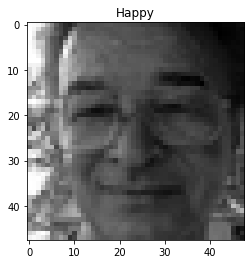

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']
for i in range (25):
  plt.title(emotions[y_train[i].argmax()])
  plt.imshow(X_train[i][:,:,0], cmap='gray')
  plt.show()

Image Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 
testgen = ImageDataGenerator(rescale=1./255)
testgen.fit(X_train)
batch_size = 128

train_flow = testgen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

Building CNN model

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam

Architecture

In [ ]:
model=Sequential()

# 1st layer
model.add(Conv2D(filters=64,kernel_size=3,activation='relu',padding="same",input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))
# 2nd layer
model.add(Conv2D(filters=128,kernel_size=3,activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
# 3rd layer
model.add(Conv2D(filters=256,kernel_size=3,activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
# 4th layer
model.add(Conv2D(filters=256,kernel_size=3,activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dense(7,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 128)       0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000015), metrics=['accuracy'])
num_epochs = 100
history = model.fit(train_flow,validation_data=test_flow,batch_size=batch_size,epochs=num_epochs, steps_per_epoch=len(train_flow), validation_steps=len(test_flow))

Epoch 1/100
225/225 [==============================] - 19s 34ms/step - loss: 2.0453 - accuracy: 0.1760 - val_loss: 1.8936 - val_accuracy: 0.2204
Epoch 2/100
225/225 [==============================] - 7s 32ms/step - loss: 1.8956 - accuracy: 0.2015 - val_loss: 1.8637 - val_accuracy: 0.1871
Epoch 3/100
225/225 [==============================] - 7s 32ms/step - loss: 1.8482 - accuracy: 0.2208 - val_loss: 1.9199 - val_accuracy: 0.2022
Epoch 4/100
225/225 [==============================] - 7s 32ms/step - loss: 1.8222 - accuracy: 0.2394 - val_loss: 1.9694 - val_accuracy: 0.2412
Epoch 5/100
225/225 [==============================] - 7s 32ms/step - loss: 1.8076 - accuracy: 0.2490 - val_loss: 1.9609 - val_accuracy: 0.2695
Epoch 6/100
225/225 [==============================] - 7s 33ms/step - loss: 1.7885 - accuracy: 0.2663 - val_loss: 1.9494 - val_accuracy: 0.2684
Epoch 7/100
225/225 [==============================] - 7s 32ms/step - loss: 1.7779 - accuracy: 0.2735 - val_loss: 1.9289 - val_accuracy

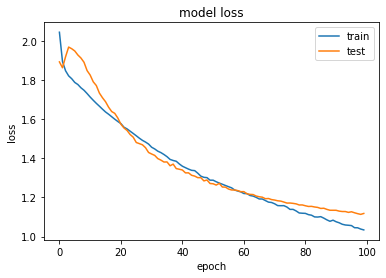

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
plt.savefig('loss')

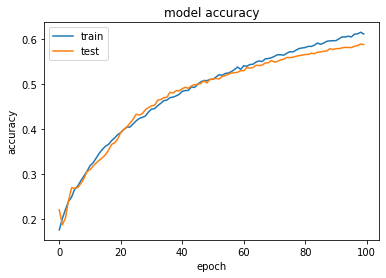

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('acc')

In [ ]:
model_json = model.to_json()
model.save('path/to/location')
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")